In [1]:
import os
import torch
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import Util


In [2]:
# CSV path
folder_name = "data"
file_name = "hungary_chickenpox.csv"
path = os.path.join(folder_name, file_name)
#Load CSV into Dataframe
df = pd.read_csv(path,sep=',')
df = df.drop(columns = ['Date'])

Preprocess Data

In [3]:
# sns.pairplot(df)

In [4]:
class Discriminator(nn.Module):
    # Classifies data as real or synthetic, used to train generator
    # Consists of 3 sequential linear layers, standerdized by dropout
    # Uses a Relu activation function
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(df_dim, (batch_size*8)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*8), (batch_size*4)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*4), (batch_size*2)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*2), 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    


In [5]:
class Generator(nn.Module):
    # Generates synthetic data
    # Consists of 3 sequential linear layers, standerdized by dropout
    # Uses a Relu activation function
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(df_dim, (batch_size)),
            nn.ReLU(),
            nn.Linear((batch_size), (batch_size*2)),
            nn.ReLU(),
            nn.Linear((batch_size*2), df_dim),
        )

    def forward(self, x):
        output = self.model(x)
        return output



This training loop is for validation data

In [6]:
def training_loop(num_epochs, train_loader, val_loader, lr=0.002, early_stopping_patience=50):
# This is where the generator and discrimator are trained
    # loss function
    loss_function = nn.BCELoss()
    # Optimizer
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
    
    best_val_loss = float('inf')
    patience = 0
    for epoch in range(num_epochs):

        for n, (real_samples, _) in enumerate(train_loader):

        # Data for training the discriminator
            real_samples_labels = torch.ones((batch_size, 1))
            latent_space_samples = torch.randn((batch_size, df_dim))
            generated_samples = generator(latent_space_samples)
            generated_samples_labels = torch.zeros((batch_size, 1))
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

        # Data for training the generator
            latent_space_samples = torch.randn((batch_size, df_dim))

        # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()
        
    # Train on validation dataset
        with torch.no_grad():
            val_loss_discriminator = 0
            val_loss_generator = 0
            for val_samples, _ in val_loader:
                # Data for validation
                real_samples_labels_val = torch.ones((batch_size, 1))
                latent_space_samples_val = torch.randn((batch_size, df_dim))
                generated_samples_val = generator(latent_space_samples)
                generated_samples_labels_val = torch.zeros((batch_size, 1))
                all_samples_val = torch.cat((real_samples, generated_samples))
                all_samples_labels_val = torch.cat((real_samples_labels, generated_samples_labels))

                # Calculate loss on validation dataset
                output_discriminator_val = discriminator(all_samples_val)
                val_loss_discriminator += loss_function(output_discriminator_val, all_samples_labels_val).item()

                output_discriminator_generated_val = discriminator(generated_samples_val)
                val_loss_generator += loss_function(output_discriminator_generated_val, real_samples_labels_val).item()

            # Average loss on validation dataset
            val_loss_discriminator /= len(val_loader)
            val_loss_generator /= len(val_loader)
            print(f"Epoch: {epoch} Validation Loss D.: {val_loss_discriminator:.4f}, Validation Loss G.: {val_loss_generator:.4f}")
           
            
            # Check for early stopping
#             if val_loss_discriminator < best_val_loss:
#                 best_val_loss = val_loss_discriminator
#                 patience = 0
#             else:
#                 patience += 1
#                 if patience >= early_stopping_patience:
#                     print(f"Stopping early after {epoch} epochs with no improvement in validation loss")
#                     return

This training loop is for no val data

In [7]:
# def training_loop(num_epochs, train_loader, lr=0.002):
# # This is where the generator and discrimator are trained
#     # loss function 
#     loss_function = nn.BCELoss()
#     # Optimizer 
#     optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
#     optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
#     # Main training loo[]
#     for epoch in range(num_epochs):

#         for n, (real_samples, _) in enumerate(train_loader):

#         # Data for training the discriminator
#             # sample labels 1 for real 0 for fake
#             # latent space samples are thge noise fed into the generator
#             real_samples_labels = torch.ones((batch_size, 1))
#             latent_space_samples = torch.randn((batch_size, df_dim))
#             generated_samples = generator(latent_space_samples)
#             generated_samples_labels = torch.zeros((batch_size, 1))
#             # after loading the real and generating the fake we combine these as the input to discriminator
#             all_samples = torch.cat((real_samples, generated_samples))
#             all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

#         # Training the discriminator
#             # Zero the gradient from previous batch so we dont impact current batch
#             discriminator.zero_grad()
#             output_discriminator = discriminator(all_samples)
#             # calculate loss based on discriminator output
#             loss_discriminator = loss_function(output_discriminator, all_samples_labels)
#             # Back propagate and update model parameters based on the loss
#             loss_discriminator.backward()
#             optimizer_discriminator.step()

#         # Data for training the generator
#             # Generate noise for generator
#             latent_space_samples = torch.randn((batch_size, df_dim))

#         # Training the generator
#             # Zero the gradient from previous batch so we dont impact current batch
#             generator.zero_grad()
#             generated_samples = generator(latent_space_samples)
#             # Here the generated samples are fed to the discrimiator to determine the quality of gen data
#             output_discriminator_generated = discriminator(generated_samples)
#             # Calculate loss update model parameters
#             loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
#             loss_generator.backward()
#             optimizer_generator.step()
#         # Show loss
#             if epoch % 10 == 0 and n == batch_size - 1:
#                 print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
#                 print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [8]:
# Get column names
names = Util.get_column_names(df)

In [9]:
# Set random state
torch.manual_seed(111)
# Select # of data points from data set to train GAN
num_data = 450
# Specify Validation Data
val_data = 50
# Specify dimensionality of dataframe
df_dim = len(df.columns)
# learning rate
lr = 0.002
# number of epoch
num_epochs = 1000
# Discriminator and Generator dropout fro data standardization
drop_out=0.3
# Define batch size for the data loader
batch_size = 25


# These create the arrays and then turns them into tensors for the train loader 
arrays = Util.create_arrays(df[:num_data],num_data)
train_set = Util.create_tensors(arrays)
# val set
val_arrays = Util.create_arrays(df[num_data:],val_data)
val_set = Util.create_tensors(val_arrays)
# Define discriminator and generator for training function
discriminator = Discriminator()
generator = Generator()

In [10]:
# Specify Time window for time step input
window = batch_size
num_samples = int(num_data / window)
array_edges = torch.tensor(np.arange(1,num_data,window))

In [11]:
# This makes bins of tensors to feed into the training function
tensor_pieces = []
for i in range(0, len(train_set), window):
    # Add the next 5 tuples as a list to the new list
    tensor_pieces.append(list(train_set[i:i+window]))

In [12]:
# The train loader loads the data into the neural network trainer
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)

Train the model using either time steps or single input by uncommenting one and commenting the other

In [13]:
# This takes time steps as inputs

# n = len(tensor_pieces)
# for i in range(n):
#     train_loader = torch.utils.data.DataLoader(tensor_pieces[0], batch_size=batch_size)
#     training_loop(num_epochs, train_loader, lr)

In [14]:
# This takes the trining dataframe as input
# training_loop(num_epochs, train_loader, lr)
# This takes the entire dataframe as input (Val Data Only)
training_loop(num_epochs, train_loader, val_loader, lr, early_stopping_patience=10)

Epoch: 0 Validation Loss D.: 0.3109, Validation Loss G.: 0.7672
Epoch: 1 Validation Loss D.: 0.2787, Validation Loss G.: 0.8972
Epoch: 2 Validation Loss D.: 0.1886, Validation Loss G.: 1.1788
Epoch: 3 Validation Loss D.: 0.1219, Validation Loss G.: 1.5282
Epoch: 4 Validation Loss D.: 0.3630, Validation Loss G.: 0.6827
Epoch: 5 Validation Loss D.: 0.5385, Validation Loss G.: 1.0591
Epoch: 6 Validation Loss D.: 0.3569, Validation Loss G.: 1.0189
Epoch: 7 Validation Loss D.: 0.1791, Validation Loss G.: 1.8666
Epoch: 8 Validation Loss D.: 0.2749, Validation Loss G.: 0.8359
Epoch: 9 Validation Loss D.: 0.1628, Validation Loss G.: 1.3783
Epoch: 10 Validation Loss D.: 0.1593, Validation Loss G.: 1.2801
Epoch: 11 Validation Loss D.: 0.3018, Validation Loss G.: 1.8156
Epoch: 12 Validation Loss D.: 0.0756, Validation Loss G.: 2.1692
Epoch: 13 Validation Loss D.: 0.0222, Validation Loss G.: 4.2986
Epoch: 14 Validation Loss D.: 0.2285, Validation Loss G.: 0.9721
Epoch: 15 Validation Loss D.: 0.149

Epoch: 130 Validation Loss D.: 0.0923, Validation Loss G.: 3.5842
Epoch: 131 Validation Loss D.: 0.1226, Validation Loss G.: 3.1703
Epoch: 132 Validation Loss D.: 0.0826, Validation Loss G.: 3.7839
Epoch: 133 Validation Loss D.: 0.1091, Validation Loss G.: 2.4699
Epoch: 134 Validation Loss D.: 0.0417, Validation Loss G.: 3.5780
Epoch: 135 Validation Loss D.: 0.1095, Validation Loss G.: 3.1388
Epoch: 136 Validation Loss D.: 0.0856, Validation Loss G.: 3.5564
Epoch: 137 Validation Loss D.: 0.0843, Validation Loss G.: 2.7782
Epoch: 138 Validation Loss D.: 0.1217, Validation Loss G.: 2.5938
Epoch: 139 Validation Loss D.: 0.1116, Validation Loss G.: 2.7161
Epoch: 140 Validation Loss D.: 0.1920, Validation Loss G.: 2.6924
Epoch: 141 Validation Loss D.: 0.1302, Validation Loss G.: 3.0428
Epoch: 142 Validation Loss D.: 0.0864, Validation Loss G.: 3.5720
Epoch: 143 Validation Loss D.: 0.1253, Validation Loss G.: 2.7408
Epoch: 144 Validation Loss D.: 0.1869, Validation Loss G.: 3.3369
Epoch: 145

Epoch: 255 Validation Loss D.: 0.3441, Validation Loss G.: 1.5657
Epoch: 256 Validation Loss D.: 0.3206, Validation Loss G.: 1.8524
Epoch: 257 Validation Loss D.: 0.4751, Validation Loss G.: 2.2154
Epoch: 258 Validation Loss D.: 0.3436, Validation Loss G.: 2.2638
Epoch: 259 Validation Loss D.: 0.2823, Validation Loss G.: 2.1192
Epoch: 260 Validation Loss D.: 0.3776, Validation Loss G.: 1.7322
Epoch: 261 Validation Loss D.: 0.4189, Validation Loss G.: 1.6416
Epoch: 262 Validation Loss D.: 0.3850, Validation Loss G.: 1.5657
Epoch: 263 Validation Loss D.: 0.4226, Validation Loss G.: 1.9496
Epoch: 264 Validation Loss D.: 0.3393, Validation Loss G.: 2.1064
Epoch: 265 Validation Loss D.: 0.4027, Validation Loss G.: 2.0058
Epoch: 266 Validation Loss D.: 0.4630, Validation Loss G.: 2.2031
Epoch: 267 Validation Loss D.: 0.4416, Validation Loss G.: 2.0120
Epoch: 268 Validation Loss D.: 0.4756, Validation Loss G.: 1.5850
Epoch: 269 Validation Loss D.: 0.4441, Validation Loss G.: 2.0876
Epoch: 270

Epoch: 380 Validation Loss D.: 0.3282, Validation Loss G.: 1.6221
Epoch: 381 Validation Loss D.: 0.5335, Validation Loss G.: 1.6344
Epoch: 382 Validation Loss D.: 0.5735, Validation Loss G.: 1.9231
Epoch: 383 Validation Loss D.: 0.6628, Validation Loss G.: 1.2773
Epoch: 384 Validation Loss D.: 0.5373, Validation Loss G.: 1.6107
Epoch: 385 Validation Loss D.: 0.4198, Validation Loss G.: 1.9877
Epoch: 386 Validation Loss D.: 0.5028, Validation Loss G.: 1.4651
Epoch: 387 Validation Loss D.: 0.5306, Validation Loss G.: 1.3747
Epoch: 388 Validation Loss D.: 0.7473, Validation Loss G.: 1.4661
Epoch: 389 Validation Loss D.: 0.4957, Validation Loss G.: 1.5786
Epoch: 390 Validation Loss D.: 0.5333, Validation Loss G.: 1.4123
Epoch: 391 Validation Loss D.: 0.6902, Validation Loss G.: 1.3734
Epoch: 392 Validation Loss D.: 0.5306, Validation Loss G.: 1.3298
Epoch: 393 Validation Loss D.: 0.5479, Validation Loss G.: 1.8154
Epoch: 394 Validation Loss D.: 0.4594, Validation Loss G.: 1.7019
Epoch: 395

Epoch: 505 Validation Loss D.: 0.4228, Validation Loss G.: 1.2540
Epoch: 506 Validation Loss D.: 0.5108, Validation Loss G.: 1.4794
Epoch: 507 Validation Loss D.: 0.5340, Validation Loss G.: 1.5848
Epoch: 508 Validation Loss D.: 0.5346, Validation Loss G.: 1.3190
Epoch: 509 Validation Loss D.: 0.4143, Validation Loss G.: 1.6336
Epoch: 510 Validation Loss D.: 0.4347, Validation Loss G.: 1.9724
Epoch: 511 Validation Loss D.: 0.5693, Validation Loss G.: 1.8826
Epoch: 512 Validation Loss D.: 0.6310, Validation Loss G.: 1.4823
Epoch: 513 Validation Loss D.: 0.5315, Validation Loss G.: 1.2884
Epoch: 514 Validation Loss D.: 0.5875, Validation Loss G.: 1.2711
Epoch: 515 Validation Loss D.: 0.6233, Validation Loss G.: 1.6623
Epoch: 516 Validation Loss D.: 0.4501, Validation Loss G.: 1.3773
Epoch: 517 Validation Loss D.: 0.6673, Validation Loss G.: 1.5898
Epoch: 518 Validation Loss D.: 0.4892, Validation Loss G.: 1.4544
Epoch: 519 Validation Loss D.: 0.3724, Validation Loss G.: 1.3576
Epoch: 520

Epoch: 633 Validation Loss D.: 0.4215, Validation Loss G.: 1.7785
Epoch: 634 Validation Loss D.: 0.4400, Validation Loss G.: 1.5253
Epoch: 635 Validation Loss D.: 0.3643, Validation Loss G.: 1.5082
Epoch: 636 Validation Loss D.: 0.5183, Validation Loss G.: 1.6776
Epoch: 637 Validation Loss D.: 0.4631, Validation Loss G.: 1.5560
Epoch: 638 Validation Loss D.: 0.4875, Validation Loss G.: 1.3684
Epoch: 639 Validation Loss D.: 0.4431, Validation Loss G.: 1.3802
Epoch: 640 Validation Loss D.: 0.4043, Validation Loss G.: 1.4022
Epoch: 641 Validation Loss D.: 0.3359, Validation Loss G.: 1.6127
Epoch: 642 Validation Loss D.: 0.2454, Validation Loss G.: 1.6467
Epoch: 643 Validation Loss D.: 0.2486, Validation Loss G.: 1.6110
Epoch: 644 Validation Loss D.: 0.5107, Validation Loss G.: 1.4374
Epoch: 645 Validation Loss D.: 0.5398, Validation Loss G.: 1.6278
Epoch: 646 Validation Loss D.: 0.4804, Validation Loss G.: 1.3793
Epoch: 647 Validation Loss D.: 0.4310, Validation Loss G.: 1.4939
Epoch: 648

Epoch: 758 Validation Loss D.: 0.3851, Validation Loss G.: 1.5353
Epoch: 759 Validation Loss D.: 0.5744, Validation Loss G.: 1.5230
Epoch: 760 Validation Loss D.: 0.4382, Validation Loss G.: 1.3236
Epoch: 761 Validation Loss D.: 0.4411, Validation Loss G.: 1.4266
Epoch: 762 Validation Loss D.: 0.3727, Validation Loss G.: 1.7210
Epoch: 763 Validation Loss D.: 0.4939, Validation Loss G.: 1.3543
Epoch: 764 Validation Loss D.: 0.3404, Validation Loss G.: 1.4447
Epoch: 765 Validation Loss D.: 0.3216, Validation Loss G.: 1.6883
Epoch: 766 Validation Loss D.: 0.4479, Validation Loss G.: 1.4462
Epoch: 767 Validation Loss D.: 0.4495, Validation Loss G.: 1.0082
Epoch: 768 Validation Loss D.: 0.3932, Validation Loss G.: 1.6934
Epoch: 769 Validation Loss D.: 0.3948, Validation Loss G.: 1.7945
Epoch: 770 Validation Loss D.: 0.4606, Validation Loss G.: 1.7344
Epoch: 771 Validation Loss D.: 0.4573, Validation Loss G.: 1.7501
Epoch: 772 Validation Loss D.: 0.3332, Validation Loss G.: 1.7133
Epoch: 773

Epoch: 883 Validation Loss D.: 0.3916, Validation Loss G.: 1.7720
Epoch: 884 Validation Loss D.: 0.4759, Validation Loss G.: 1.4076
Epoch: 885 Validation Loss D.: 0.4199, Validation Loss G.: 1.6390
Epoch: 886 Validation Loss D.: 0.4755, Validation Loss G.: 1.3039
Epoch: 887 Validation Loss D.: 0.5669, Validation Loss G.: 1.2766
Epoch: 888 Validation Loss D.: 0.4097, Validation Loss G.: 1.8550
Epoch: 889 Validation Loss D.: 0.3424, Validation Loss G.: 1.9582
Epoch: 890 Validation Loss D.: 0.3598, Validation Loss G.: 1.5122
Epoch: 891 Validation Loss D.: 0.3711, Validation Loss G.: 1.5455
Epoch: 892 Validation Loss D.: 0.4719, Validation Loss G.: 1.6049
Epoch: 893 Validation Loss D.: 0.4226, Validation Loss G.: 1.9802
Epoch: 894 Validation Loss D.: 0.4440, Validation Loss G.: 1.5773
Epoch: 895 Validation Loss D.: 0.4525, Validation Loss G.: 1.4827
Epoch: 896 Validation Loss D.: 0.4396, Validation Loss G.: 1.4710
Epoch: 897 Validation Loss D.: 0.3523, Validation Loss G.: 1.4308
Epoch: 898

In [15]:
# After training the Gen, generates data as tensors
latent_space_samples = torch.randn((num_data), df_dim)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

In [16]:
# Takes the generated data and turns it into a pandas DataFrame
df_gen=pd.DataFrame(generated_samples)
df_gen = df_gen.set_axis(names, axis=1, inplace=False)


Text(0.5, 0, 'Time')

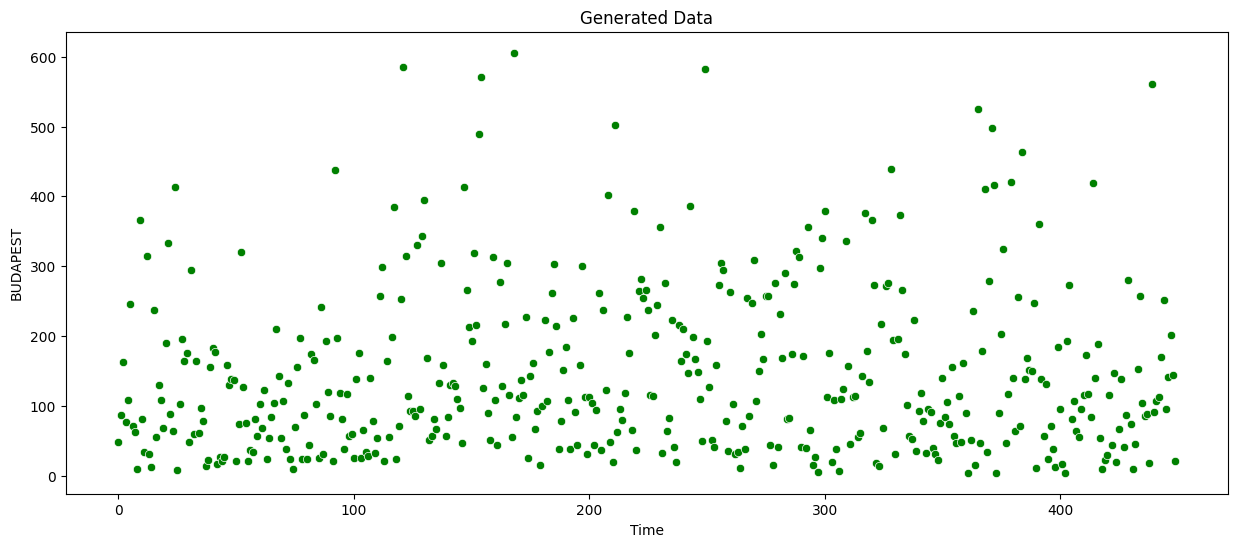

In [17]:
# Plot the generated data
fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df_gen,x=df_gen.index, y=df_gen[names[0]], color='g')
axes.set_title('Generated Data')
axes.set_xlabel("Time")

Text(0.5, 0, 'Time')

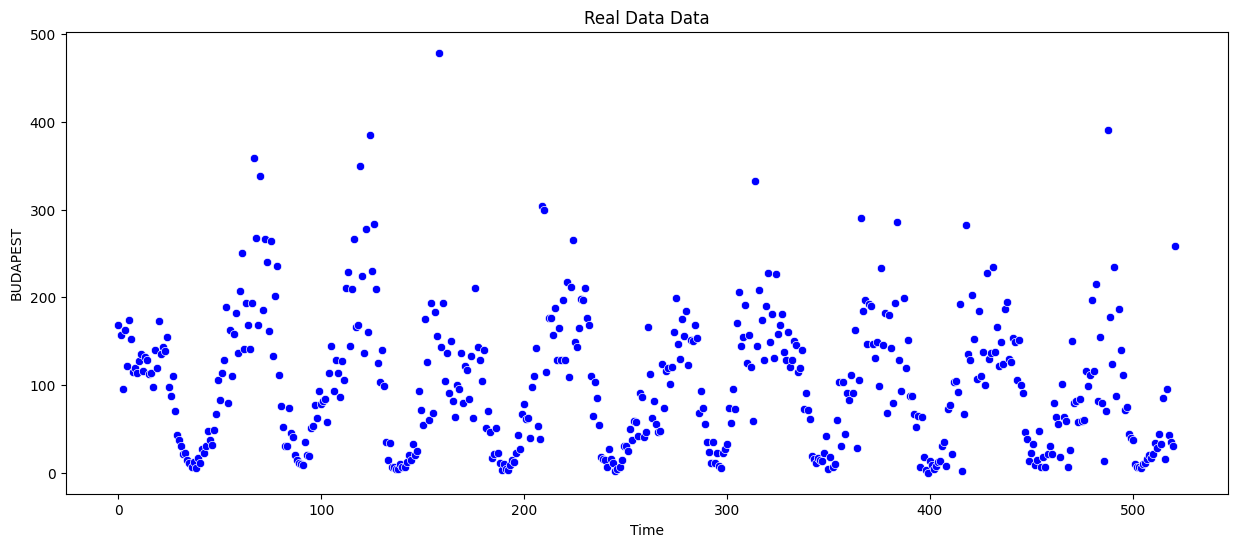

In [18]:
# This is what the real data time series looks like

fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df,x=df.index, y=df[names[0]], color='b')
axes.set_title('Real Data Data')
axes.set_xlabel("Time")

In [19]:
# sns.pairplot(df_gen)

Text(0.5, 1.0, 'Real vs Generated Data')

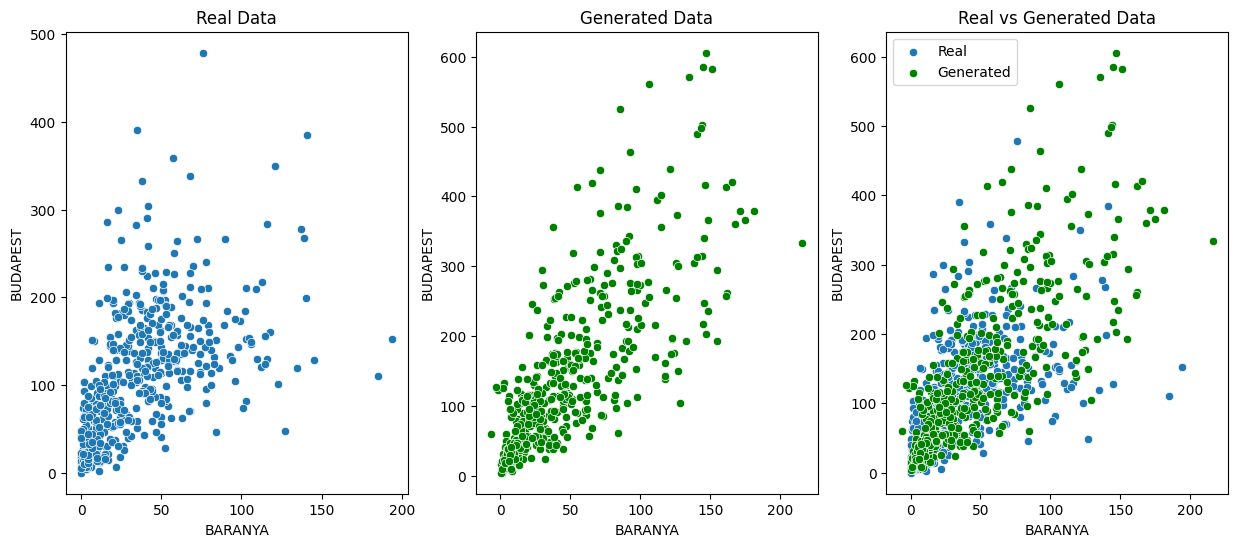

In [20]:
# Plotting Real vs Generated data
fig, axes = plt.subplots(1, 3, figsize=(15, 6))


sns.scatterplot(ax=axes[0],x=names[1], y=names[0], data=df)
axes[0].set_title('Real Data')

sns.scatterplot(ax=axes[1], data=df_gen,x=names[1], y=df_gen[names[0]], color='g')
axes[1].set_title('Generated Data')

sns.scatterplot(ax=axes[2], data=df, x=names[1], y=names[0], label='Real')
sns.scatterplot(ax=axes[2], data=df_gen, x=names[1], y=names[0], color='g', label= 'Generated')
axes[2].set_title('Real vs Generated Data')


In [21]:
print('Current Model Parameters:')
print('Size of dataset:', num_data)
print('Number of epochs:', num_epochs)
print('Learning Rate:', lr)
print('Discriminator dropout:', drop_out)
print('Batch Size:', batch_size)

Current Model Parameters:
Size of dataset: 450
Number of epochs: 1000
Learning Rate: 0.002
Discriminator dropout: 0.3
Batch Size: 25
